## Notebook para treinar o modelo que irá prever os Churns

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
from Utils.DataTransformer import DataTransformer
from Utils.DuckDb.DuckDb import DuckDb
from Utils.DatasetProcessor.DatasetProcessorUtils import DatasetProcessorUtils
from datetime import datetime
import pandas as pd
from typing import Dict
from Utils import PandasNotebookConfigs
import project_config
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import recall_score, f1_score

/home/caio/Git-Projetos/2025-case-data-master-caio-arrabal/env/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 9.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [3]:
PandasNotebookConfigs.config()

Ajustando display.float.format para %.4f
Ajustando prints de linhas e colunas


In [4]:
DUCK_DB_UTILS = DuckDb()
DATA_TRANSFORMER = DataTransformer()
DATA_PROCESSOR_UTILS = DatasetProcessorUtils(DUCK_DB_UTILS)

In [5]:
TABLE_NAME = project_config.PRE_PREPARED_DATA_TABLE

In [6]:
df = DUCK_DB_UTILS.load_table(
    TABLE_NAME,
    limit = 100_000,
    where_condition=f'WHERE safra <= {project_config.TEST_DATA_UNTIL_SAFRA}' # We'll split train data and validation data later
)

In [7]:
len(df)

100000

In [8]:
df.head()

,cost,msno,safra,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,total_hours,msno_1,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,safra_1,transaction_date_year,transaction_date_month,transaction_date_day,transaction_date_day_of_week,transaction_date_day_of_year,membership_expire_date_year,membership_expire_date_month,membership_expire_date_day,membership_expire_date_day_of_week,membership_expire_date_day_of_year,discount,price_per_month,members_msno,members_safra,city,registered_via,is_active,registration_init_time_year,registration_init_time_month,registration_init_time_day,registration_init_time_day_of_week,registration_init_time_day_of_year,_filled_out_members_info,is_churn,no_churn_information,num_unq-2M,num_unq-1M,total_secs-2M,total_secs-1M,num_25-2M,num_25-1M,num_50-2M,num_50-1M,num_75-2M,num_75-1M,num_985-2M,num_985-1M,num_100-2M,num_100-1M
0,55.9125,+++FOrTS7ab3tIgIh8eWwX4FqRv8w/FoiOuyXsFvphY=,201609,60,12,14,7,171,179,49996,13.8878,+++FOrTS7ab3tIgIh8eWwX4FqRv8w/FoiOuyXsFvphY=,35,7,0,0,False,False,201609,2016,9,9,4,253,2016,9,14,2,258,0,0.0000,+++FOrTS7ab3tIgIh8eWwX4FqRv8w/FoiOuyXsFvphY=,201609,15,9,True,2004,3,27,5,87,Infos já existentes,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,67.3556,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,201611,128,71,50,101,470,488,148668,41.2967,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,41,30,99,99,True,False,201611,2016,11,16,2,321,2016,12,15,3,350,0,99.0000,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,201611,1,7,True,2014,6,8,6,159,Infos já existentes,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,52.9465,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,201501,58,8,4,2,82,137,22478,6.2439,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,39,31,149,149,True,False,201501,2015,1,31,5,31,2015,3,19,3,78,0,144.1935,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,<NA>,15,9,True,2010,11,18,3,322,Copiadas,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,55.5166,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,201502,27,5,4,3,203,136,48230,13.3972,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,39,31,149,149,True,False,201502,2015,2,28,5,59,2015,4,19,6,109,0,144.1935,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,<NA>,15,9,True,2010,11,18,3,322,Copiadas,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,52.6188,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,201503,37,15,6,8,73,94,21394,5.9428,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,39,31,149,149,True,False,201503,2015,3,31,1,90,2015,5,19,1,139,0,144.1935,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,<NA>,15,9,True,2010,11,18,3,322,Copiadas,False,False,137.0000,136.0000,22478.0000,48230.0000,58.0000,27.0000,8.0000,5.0000,4.0000,4.0000,2.0000,3.0000,82.0000,203.0000


In [9]:
df = DATA_PROCESSOR_UTILS.calc_remaining_days(df)

In [10]:
df.head()

,cost,msno,safra,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,total_hours,msno_1,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,safra_1,transaction_date_year,transaction_date_month,transaction_date_day,transaction_date_day_of_week,transaction_date_day_of_year,membership_expire_date_year,membership_expire_date_month,membership_expire_date_day,membership_expire_date_day_of_week,membership_expire_date_day_of_year,discount,price_per_month,members_msno,members_safra,city,registered_via,is_active,registration_init_time_year,registration_init_time_month,registration_init_time_day,registration_init_time_day_of_week,registration_init_time_day_of_year,_filled_out_members_info,is_churn,no_churn_information,num_unq-2M,num_unq-1M,total_secs-2M,total_secs-1M,num_25-2M,num_25-1M,num_50-2M,num_50-1M,num_75-2M,num_75-1M,num_985-2M,num_985-1M,num_100-2M,num_100-1M,remaining_days
0,55.9125,+++FOrTS7ab3tIgIh8eWwX4FqRv8w/FoiOuyXsFvphY=,201609,60,12,14,7,171,179,49996,13.8878,+++FOrTS7ab3tIgIh8eWwX4FqRv8w/FoiOuyXsFvphY=,35,7,0,0,False,False,201609,2016,9,9,4,253,2016,9,14,2,258,0,0.0000,+++FOrTS7ab3tIgIh8eWwX4FqRv8w/FoiOuyXsFvphY=,201609,15,9,True,2004,3,27,5,87,Infos já existentes,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0000
1,67.3556,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,201611,128,71,50,101,470,488,148668,41.2967,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,41,30,99,99,True,False,201611,2016,11,16,2,321,2016,12,15,3,350,0,99.0000,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,201611,1,7,True,2014,6,8,6,159,Infos já existentes,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.0000
2,52.9465,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,201501,58,8,4,2,82,137,22478,6.2439,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,39,31,149,149,True,False,201501,2015,1,31,5,31,2015,3,19,3,78,0,144.1935,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,<NA>,15,9,True,2010,11,18,3,322,Copiadas,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.0000
3,55.5166,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,201502,27,5,4,3,203,136,48230,13.3972,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,39,31,149,149,True,False,201502,2015,2,28,5,59,2015,4,19,6,109,0,144.1935,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,<NA>,15,9,True,2010,11,18,3,322,Copiadas,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0000
4,52.6188,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,201503,37,15,6,8,73,94,21394,5.9428,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,39,31,149,149,True,False,201503,2015,3,31,1,90,2015,5,19,1,139,0,144.1935,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,<NA>,15,9,True,2010,11,18,3,322,Copiadas,False,False,137.0000,136.0000,22478.0000,48230.0000,58.0000,27.0000,8.0000,5.0000,4.0000,4.0000,2.0000,3.0000,82.0000,203.0000,49.0000


In [11]:
# Treating DF
df.isna().sum().T

cost                                      0
msno                                      0
safra                                     0
num_25                                    0
num_50                                    0
num_75                                    0
num_985                                   0
num_100                                   0
num_unq                                   0
total_secs                                0
total_hours                               0
msno_1                                    0
payment_method_id                         0
payment_plan_days                         0
plan_list_price                           0
actual_amount_paid                        0
is_auto_renew                             0
is_cancel                                 0
safra_1                                   0
transaction_date_year                     0
transaction_date_month                    0
transaction_date_day                      0
transaction_date_day_of_week    

In [12]:
df.head()

,cost,msno,safra,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,total_hours,msno_1,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,safra_1,transaction_date_year,transaction_date_month,transaction_date_day,transaction_date_day_of_week,transaction_date_day_of_year,membership_expire_date_year,membership_expire_date_month,membership_expire_date_day,membership_expire_date_day_of_week,membership_expire_date_day_of_year,discount,price_per_month,members_msno,members_safra,city,registered_via,is_active,registration_init_time_year,registration_init_time_month,registration_init_time_day,registration_init_time_day_of_week,registration_init_time_day_of_year,_filled_out_members_info,is_churn,no_churn_information,num_unq-2M,num_unq-1M,total_secs-2M,total_secs-1M,num_25-2M,num_25-1M,num_50-2M,num_50-1M,num_75-2M,num_75-1M,num_985-2M,num_985-1M,num_100-2M,num_100-1M,remaining_days
0,55.9125,+++FOrTS7ab3tIgIh8eWwX4FqRv8w/FoiOuyXsFvphY=,201609,60,12,14,7,171,179,49996,13.8878,+++FOrTS7ab3tIgIh8eWwX4FqRv8w/FoiOuyXsFvphY=,35,7,0,0,False,False,201609,2016,9,9,4,253,2016,9,14,2,258,0,0.0000,+++FOrTS7ab3tIgIh8eWwX4FqRv8w/FoiOuyXsFvphY=,201609,15,9,True,2004,3,27,5,87,Infos já existentes,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0000
1,67.3556,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,201611,128,71,50,101,470,488,148668,41.2967,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,41,30,99,99,True,False,201611,2016,11,16,2,321,2016,12,15,3,350,0,99.0000,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,201611,1,7,True,2014,6,8,6,159,Infos já existentes,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.0000
2,52.9465,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,201501,58,8,4,2,82,137,22478,6.2439,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,39,31,149,149,True,False,201501,2015,1,31,5,31,2015,3,19,3,78,0,144.1935,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,<NA>,15,9,True,2010,11,18,3,322,Copiadas,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.0000
3,55.5166,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,201502,27,5,4,3,203,136,48230,13.3972,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,39,31,149,149,True,False,201502,2015,2,28,5,59,2015,4,19,6,109,0,144.1935,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,<NA>,15,9,True,2010,11,18,3,322,Copiadas,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0000
4,52.6188,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,201503,37,15,6,8,73,94,21394,5.9428,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,39,31,149,149,True,False,201503,2015,3,31,1,90,2015,5,19,1,139,0,144.1935,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,<NA>,15,9,True,2010,11,18,3,322,Copiadas,False,False,137.0000,136.0000,22478.0000,48230.0000,58.0000,27.0000,8.0000,5.0000,4.0000,4.0000,2.0000,3.0000,82.0000,203.0000,49.0000


In [14]:
df.head()

,cost,msno,safra,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,total_hours,msno_1,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,safra_1,transaction_date_year,transaction_date_month,transaction_date_day,transaction_date_day_of_week,transaction_date_day_of_year,membership_expire_date_year,membership_expire_date_month,membership_expire_date_day,membership_expire_date_day_of_week,membership_expire_date_day_of_year,discount,price_per_month,members_msno,members_safra,city,registered_via,is_active,registration_init_time_year,registration_init_time_month,registration_init_time_day,registration_init_time_day_of_week,registration_init_time_day_of_year,_filled_out_members_info,is_churn,no_churn_information,num_unq-2M,num_unq-1M,total_secs-2M,total_secs-1M,num_25-2M,num_25-1M,num_50-2M,num_50-1M,num_75-2M,num_75-1M,num_985-2M,num_985-1M,num_100-2M,num_100-1M,remaining_days
0,55.9125,+++FOrTS7ab3tIgIh8eWwX4FqRv8w/FoiOuyXsFvphY=,201609,60,12,14,7,171,179,49996,13.8878,+++FOrTS7ab3tIgIh8eWwX4FqRv8w/FoiOuyXsFvphY=,35,7,0,0,False,False,201609,2016,9,9,4,253,2016,9,14,2,258,0,0.0000,+++FOrTS7ab3tIgIh8eWwX4FqRv8w/FoiOuyXsFvphY=,201609,15,9,True,2004,3,27,5,87,Infos já existentes,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0000
1,67.3556,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,201611,128,71,50,101,470,488,148668,41.2967,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,41,30,99,99,True,False,201611,2016,11,16,2,321,2016,12,15,3,350,0,99.0000,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,201611,1,7,True,2014,6,8,6,159,Infos já existentes,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.0000
2,52.9465,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,201501,58,8,4,2,82,137,22478,6.2439,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,39,31,149,149,True,False,201501,2015,1,31,5,31,2015,3,19,3,78,0,144.1935,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,<NA>,15,9,True,2010,11,18,3,322,Copiadas,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.0000
3,55.5166,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,201502,27,5,4,3,203,136,48230,13.3972,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,39,31,149,149,True,False,201502,2015,2,28,5,59,2015,4,19,6,109,0,144.1935,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,<NA>,15,9,True,2010,11,18,3,322,Copiadas,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0000
4,52.6188,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,201503,37,15,6,8,73,94,21394,5.9428,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,39,31,149,149,True,False,201503,2015,3,31,1,90,2015,5,19,1,139,0,144.1935,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,<NA>,15,9,True,2010,11,18,3,322,Copiadas,False,False,137.0000,136.0000,22478.0000,48230.0000,58.0000,27.0000,8.0000,5.0000,4.0000,4.0000,2.0000,3.0000,82.0000,203.0000,49.0000


In [15]:
df.isna().sum().T

cost                                      0
msno                                      0
safra                                     0
num_25                                    0
num_50                                    0
num_75                                    0
num_985                                   0
num_100                                   0
num_unq                                   0
total_secs                                0
total_hours                               0
msno_1                                    0
payment_method_id                         0
payment_plan_days                         0
plan_list_price                           0
actual_amount_paid                        0
is_auto_renew                             0
is_cancel                                 0
safra_1                                   0
transaction_date_year                     0
transaction_date_month                    0
transaction_date_day                      0
transaction_date_day_of_week    

In [16]:
# Filtering: get labeled data to train
df = df[df['no_churn_information'] == False]

In [17]:
len(df)

100000

In [18]:
# Removing null values (when removing one, remove all)
df = df.dropna(subset=['num_unq-2M'])
len(df)

69852

In [19]:
dict(df.isna().sum().T)

{'cost': 0,
 'msno': 0,
 'safra': 0,
 'num_25': 0,
 'num_50': 0,
 'num_75': 0,
 'num_985': 0,
 'num_100': 0,
 'num_unq': 0,
 'total_secs': 0,
 'total_hours': 0,
 'msno_1': 0,
 'payment_method_id': 0,
 'payment_plan_days': 0,
 'plan_list_price': 0,
 'actual_amount_paid': 0,
 'is_auto_renew': 0,
 'is_cancel': 0,
 'safra_1': 0,
 'transaction_date_year': 0,
 'transaction_date_month': 0,
 'transaction_date_day': 0,
 'transaction_date_day_of_week': 0,
 'transaction_date_day_of_year': 0,
 'membership_expire_date_year': 0,
 'membership_expire_date_month': 0,
 'membership_expire_date_day': 0,
 'membership_expire_date_day_of_week': 0,
 'membership_expire_date_day_of_year': 0,
 'discount': 0,
 'price_per_month': 4,
 'members_msno': 0,
 'members_safra': 26905,
 'city': 0,
 'registered_via': 0,
 'is_active': 0,
 'registration_init_time_year': 0,
 'registration_init_time_month': 0,
 'registration_init_time_day': 0,
 'registration_init_time_day_of_week': 0,
 'registration_init_time_day_of_year': 0,
 

In [20]:
df = DATA_PROCESSOR_UTILS.process_categories(df)

Adicionando coluna payment_method_id_0
Adicionando coluna payment_method_id_1
Adicionando coluna payment_method_id_2
Adicionando coluna payment_method_id_3
Adicionando coluna payment_method_id_4
Adicionando coluna payment_method_id_5
Adicionando coluna payment_method_id_6
Adicionando coluna payment_method_id_7
Adicionando coluna payment_method_id_9
Adicionando coluna payment_method_id_12
Adicionando coluna payment_method_id_15
Adicionando coluna payment_method_id_17
Adicionando coluna city_0
Adicionando coluna city_2
Adicionando coluna city_19
Adicionando coluna registered_via_0
Adicionando coluna registered_via_1
Adicionando coluna registered_via_2
Adicionando coluna registered_via_5
Adicionando coluna registered_via_6
Adicionando coluna registered_via_8
Adicionando coluna registered_via_10
Adicionando coluna registered_via_11
Adicionando coluna registered_via_12
Adicionando coluna registered_via_14
Adicionando coluna registered_via_15
Adicionando coluna registered_via_16
Adicionando 

In [21]:
df.head()

,cost,msno,safra,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,total_hours,msno_1,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,safra_1,transaction_date_year,transaction_date_month,transaction_date_day,transaction_date_day_of_week,transaction_date_day_of_year,membership_expire_date_year,membership_expire_date_month,membership_expire_date_day,membership_expire_date_day_of_week,membership_expire_date_day_of_year,discount,price_per_month,members_msno,members_safra,is_active,registration_init_time_year,registration_init_time_month,registration_init_time_day,registration_init_time_day_of_week,registration_init_time_day_of_year,_filled_out_members_info,is_churn,no_churn_information,num_unq-2M,num_unq-1M,total_secs-2M,total_secs-1M,num_25-2M,num_25-1M,num_50-2M,num_50-1M,num_75-2M,num_75-1M,num_985-2M,num_985-1M,num_100-2M,num_100-1M,remaining_days,payment_method_id_8,payment_method_id_10,payment_method_id_11,payment_method_id_13,payment_method_id_14,payment_method_id_16,payment_method_id_18,payment_method_id_19,payment_method_id_20,payment_method_id_21,payment_method_id_22,payment_method_id_23,payment_method_id_24,payment_method_id_25,payment_method_id_26,payment_method_id_27,payment_method_id_28,payment_method_id_29,payment_method_id_30,payment_method_id_31,payment_method_id_32,payment_method_id_33,payment_method_id_34,payment_method_id_35,payment_method_id_36,payment_method_id_37,payment_method_id_38,payment_method_id_39,payment_method_id_40,payment_method_id_41,city_1,city_10,city_11,city_12,city_13,city_14,city_15,city_16,city_17,city_18,city_20,city_21,city_22,city_3,city_4,city_5,city_6,city_7,city_8,city_9,registered_via_13,registered_via_3,registered_via_4,registered_via_7,registered_via_9,payment_method_id_0,payment_method_id_1,payment_method_id_2,payment_method_id_3,payment_method_id_4,payment_method_id_5,payment_method_id_6,payment_method_id_7,payment_method_id_9,payment_method_id_12,payment_method_id_15,payment_method_id_17,city_0,city_2,city_19,registered_via_0,registered_via_1,registered_via_2,registered_via_5,registered_via_6,registered_via_8,registered_via_10,registered_via_11,registered_via_12,registered_via_14,registered_via_15,registered_via_16,registered_via_17,registered_via_18,registered_via_19
4,52.6188,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,201503,37,15,6,8,73,94,21394,5.9428,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,31,149,149,True,False,201503,2015,3,31,1,90,2015,5,19,1,139,0,144.1935,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,<NA>,True,2010,11,18,3,322,Copiadas,False,False,137.0000,136.0000,22478.0000,48230.0000,58.0000,27.0000,8.0000,5.0000,4.0000,4.0000,2.0000,3.0000,82.0000,203.0000,49.0000,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
5,55.4329,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,201504,30,19,21,11,157,157,46322,12.8672,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,0,0,149,True,False,201504,2015,4,30,3,120,2015,6,19,4,170,0,inf,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,<NA>,True,2010,11,18,3,322,Copiadas,False,False,136.0000,94.0000,48230.0000,21394.0000,27.0000,37.0000,5.0000,15.0000,4.0000,6.0000,3.0000,8.0000,203.0000,73.0000,50.0000,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,F

In [22]:
df = df[project_config.COLUMNS_USED_ON_TRAIN_AND_PREDICTION + [project_config.TARGET_COLUMN, 'safra']]

In [23]:
df.head()

,registration_init_time_day,registration_init_time_year,is_auto_renew,is_cancel,remaining_days,num_100,num_100-1M,num_100-2M,num_25,num_25-1M,num_25-2M,num_50,num_50-1M,num_50-2M,num_75,num_75-1M,num_75-2M,num_985,num_985-1M,num_985-2M,num_unq,num_unq-1M,num_unq-2M,total_secs,total_secs-1M,total_secs-2M,city_0,city_1,city_10,city_11,city_12,city_13,city_14,city_15,city_16,city_17,city_18,city_19,city_2,city_20,city_21,city_22,city_3,city_4,city_5,city_6,city_7,city_8,city_9,registered_via_0,registered_via_1,registered_via_10,registered_via_11,registered_via_12,registered_via_13,registered_via_14,registered_via_15,registered_via_16,registered_via_17,registered_via_18,registered_via_19,registered_via_2,registered_via_3,registered_via_4,registered_via_5,registered_via_6,registered_via_7,registered_via_8,registered_via_9,payment_method_id_0,payment_method_id_1,payment_method_id_10,payment_method_id_11,payment_method_id_12,payment_method_id_13,payment_method_id_14,payment_method_id_15,payment_method_id_16,payment_method_id_17,payment_method_id_18,payment_method_id_19,payment_method_id_2,payment_method_id_20,payment_method_id_21,payment_method_id_22,payment_method_id_23,payment_method_id_24,payment_method_id_25,payment_method_id_26,payment_method_id_27,payment_method_id_28,payment_method_id_29,payment_method_id_3,payment_method_id_30,payment_method_id_31,payment_method_id_32,payment_method_id_33,payment_method_id_34,payment_method_id_35,payment_method_id_36,payment_method_id_37,payment_method_id_38,payment_method_id_39,payment_method_id_4,payment_method_id_40,payment_method_id_41,payment_method_id_5,payment_method_id_6,payment_method_id_7,payment_method_id_8,payment_method_id_9,is_churn,safra
4,18,2010,True,False,49.0000,73,203.0000,82.0000,37,27.0000,58.0000,15,5.0000,8.0000,6,4.0000,4.0000,8,3.0000,2.0000,94,136.0000,137.0000,21394,48230.0000,22478.0000,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,201503
5,18,2010,True,False,50.0000,157,73.0000,203.0000,30,37.0000,27.0000,19,15.0000,5.0000,21,6.0000,4.0000,11,8.0000,3.0000,157,94.0000,136.0000,46322,21394.0000,48230.0000,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,201504
6,18,2010,True,False,49.0000,113,157.0000,73.0000,18,30.0000,37.0000,5,19.0000,15.0000,6,21.0000,6.0000,1,11.0000,8.0000,125,157.0000,94.0000,30584,46322.0000,21394.0000,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,201505
7,18,2010,True,False,50.0000,37,113.0000,157.0000,13,18.0000,30.0000,4,5.0000,19.0000,3,6.0000,21.0000,3,1.0000,11.0000,60,125.0000,157.0000,11007,30584.0000,46322.0000,False,False,False,False,False,False,False,True,Fa

In [25]:
# Balancing
print(f'Tamanho do DataFrame PRÉ balanceamento: {len(df)}')

true_df = df[df[project_config.TARGET_COLUMN] == True]
false_df = df[df[project_config.TARGET_COLUMN] == False]

false_df = false_df[:int(len(true_df) // 0.6)]

new_df = pd.concat([true_df, false_df])

print(f'Tamanho do DataFrame PÓS balanceamento: {len(new_df)}')

print(f'Qtd. de registros com churn = True: {len(true_df)}')
print(f'Qtd. de registros com churn = False: {len(false_df)}')

Tamanho do DataFrame PRÉ balanceamento: 69852
Tamanho do DataFrame PÓS balanceamento: 24581
Qtd. de registros com churn = True: 9218
Qtd. de registros com churn = False: 15363


In [26]:
X = new_df.drop(project_config.TARGET_COLUMN, axis=1)
y = new_df[[project_config.TARGET_COLUMN, 'safra']]

In [27]:
len(X), len(y)

(24581, 24581)

In [28]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X[X['safra'] <= project_config.TRAIN_DATA_UNTIL_SAFRA]
X_test = X[(project_config.TRAIN_DATA_UNTIL_SAFRA < X['safra']) & (X['safra'] <= project_config.TEST_DATA_UNTIL_SAFRA)]
y_train = y[y['safra'] <= project_config.TRAIN_DATA_UNTIL_SAFRA]
y_test = y[(project_config.TRAIN_DATA_UNTIL_SAFRA < y['safra']) & (y['safra'] <= project_config.TEST_DATA_UNTIL_SAFRA)]

In [29]:
len(X_train), len(X_test), len(y_train), len(y_test)

(19250, 5331, 19250, 5331)

In [30]:
X_train['safra'].describe(), X_test['safra'].describe()

(count    19250.0000
 mean    201558.9932
 std         48.3444
 min     201503.0000
 25%     201508.0000
 50%     201601.0000
 75%     201605.0000
 max     201608.0000
 Name: safra, dtype: float64,
 count     5331.0000
 mean    201610.0960
 std          0.8265
 min     201609.0000
 25%     201609.0000
 50%     201610.0000
 75%     201611.0000
 max     201611.0000
 Name: safra, dtype: float64)

In [31]:
y_train['safra'].describe(), y_test['safra'].describe()

(count    19250.0000
 mean    201558.9932
 std         48.3444
 min     201503.0000
 25%     201508.0000
 50%     201601.0000
 75%     201605.0000
 max     201608.0000
 Name: safra, dtype: float64,
 count     5331.0000
 mean    201610.0960
 std          0.8265
 min     201609.0000
 25%     201609.0000
 50%     201610.0000
 75%     201611.0000
 max     201611.0000
 Name: safra, dtype: float64)

In [32]:
X_train = X_train.drop('safra', axis=1)
X_test = X_test.drop('safra', axis=1)
y_train = y_train.drop('safra', axis=1)
y_test = y_test.drop('safra', axis=1)

In [33]:
X_train.head()

,registration_init_time_day,registration_init_time_year,is_auto_renew,is_cancel,remaining_days,num_100,num_100-1M,num_100-2M,num_25,num_25-1M,num_25-2M,num_50,num_50-1M,num_50-2M,num_75,num_75-1M,num_75-2M,num_985,num_985-1M,num_985-2M,num_unq,num_unq-1M,num_unq-2M,total_secs,total_secs-1M,total_secs-2M,city_0,city_1,city_10,city_11,city_12,city_13,city_14,city_15,city_16,city_17,city_18,city_19,city_2,city_20,city_21,city_22,city_3,city_4,city_5,city_6,city_7,city_8,city_9,registered_via_0,registered_via_1,registered_via_10,registered_via_11,registered_via_12,registered_via_13,registered_via_14,registered_via_15,registered_via_16,registered_via_17,registered_via_18,registered_via_19,registered_via_2,registered_via_3,registered_via_4,registered_via_5,registered_via_6,registered_via_7,registered_via_8,registered_via_9,payment_method_id_0,payment_method_id_1,payment_method_id_10,payment_method_id_11,payment_method_id_12,payment_method_id_13,payment_method_id_14,payment_method_id_15,payment_method_id_16,payment_method_id_17,payment_method_id_18,payment_method_id_19,payment_method_id_2,payment_method_id_20,payment_method_id_21,payment_method_id_22,payment_method_id_23,payment_method_id_24,payment_method_id_25,payment_method_id_26,payment_method_id_27,payment_method_id_28,payment_method_id_29,payment_method_id_3,payment_method_id_30,payment_method_id_31,payment_method_id_32,payment_method_id_33,payment_method_id_34,payment_method_id_35,payment_method_id_36,payment_method_id_37,payment_method_id_38,payment_method_id_39,payment_method_id_4,payment_method_id_40,payment_method_id_41,payment_method_id_5,payment_method_id_6,payment_method_id_7,payment_method_id_8,payment_method_id_9
8,18,2010,True,False,50.0000,53,37.0000,113.0000,26,13.0000,18.0000,2,4.0000,5.0000,4,3.0000,6.0000,9,3.0000,1.0000,90,60.0000,125.0000,16073,11007.0000,30584.0000,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
13,18,2010,True,False,48.0000,1050,865.0000,1176.0000,63,55.0000,65.0000,21,25.0000,19.0000,20,20.0000,15.0000,16,23.0000,19.0000,989,798.0000,992.0000,271728,229376.0000,311833.0000,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
54,22,2012,True,False,54.0000,272,105.0000,153.0000,68,21.0000,47.0000,55,30.0000,26.0000,32,9.0000,17.0000,32,16.0000,12.0000,425,175.0000,215.0000,86379,33320.0000,43177.0000,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
59,22,2012,True,False,52.0000,154,150.0000,224.0000,22,24.0000,31.0000,5,11.0000,32.0000,4,10.0000,2.0000,7,5.0000,6.0000,179,167.0000,257.0000,42039,42734.0000,60873.0000,False,False,False,False,False,False,False,False,False,False,False,False,False,Fals

Tried to use SMOTE technique, but I didn't get good results!

In [ ]:
# from imblearn.over_sampling import SMOTE

# # Apply SMOTE to the training data
# sm = SMOTE(random_state=42, n_jobs=-1)
# X_res, y_res = sm.fit_resample(X_train, y_train)

# len(X_res), len(X_test), len(y_res), len(y_test)

In [ ]:
models = {
    'Random Forest': RandomForestClassifier(
        random_state=42,
        bootstrap=False,
        max_depth=30,
        max_features='log2',
        min_samples_leaf=1,
        min_samples_split=10,
        n_estimators=100
    ),
}


def fit_and_score(models: Dict[str, RandomForestClassifier], X_train, X_test, y_train, y_test):
    '''
    Fits and evaluates given machine learning models.
    models: a dict of different Scikit-Learning machine learning models
    X_train: training data, no labels
    X_test: testing data, no labels 
    y_train: training labels
    y_test: test labels
    '''
    np.random.seed(42)

    models_scores = {}
    for name, model in models.items():
        print(f'{datetime.now()} Treinando {name}...')
        model.fit(X_train, y_train)

        print(f'{datetime.now()} Predicting {name}...')
        y_preds = model.predict(X_test)

        score_f1 = f1_score(y_test, y_preds)
        print(f'{datetime.now()} Score (f1_score): {score_f1}...')

        recall = recall_score(y_test, y_preds)
        print(f'{datetime.now()} Score (recall): {recall}...')

        default_score = model.score(X_test, y_test)
        print(f'{datetime.now()} Score (default_score): {default_score}...')

        print(
            classification_report(y_test, y_preds)
        )

        matrix = confusion_matrix(y_test, y_preds)

        print(matrix)
        print('\n')

        models_scores[name] = {
            'f1_score': score_f1,
            'recall': recall,
            'default_score': default_score,
            'cofusion_matrix': matrix
        }

    return models_scores

In [37]:
model_scores = fit_and_score(models, X_train, X_test, y_train, y_test)
model_scores

2025-04-08 19:19:46.151878 Treinando Random Forest...


/home/caio/Git-Projetos/2025-case-data-master-caio-arrabal/env/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


2025-04-08 19:19:50.137872 Predict Random Forest...
2025-04-08 19:19:50.238901 Score (f1_score): 0.6055654837886137...
2025-04-08 19:19:50.243543 Score (recall): 0.5226972234464522...
2025-04-08 19:19:50.338623 Score (default_score): 0.7101857062464828...
              precision    recall  f1-score   support

       False       0.71      0.85      0.77      3062
        True       0.72      0.52      0.61      2269

    accuracy                           0.71      5331
   macro avg       0.71      0.69      0.69      5331
weighted avg       0.71      0.71      0.70      5331

[[2600  462]
 [1083 1186]]




{'Random Forest': {'f1_score': 0.6055654837886137,
  'recall': 0.5226972234464522,
  'default_score': 0.7101857062464828,
  'cofusion_matrix': array([[2600,  462],
         [1083, 1186]])}}

Best model results:
```
             precision    recall  f1-score   support

       False       0.71      0.85      0.77      3062
        True       0.72      0.52      0.61      2269

    accuracy                           0.71      5331
   macro avg       0.71      0.69      0.69      5331
weighted avg       0.71      0.71      0.70      5331

[[2600  462]
 [1083 1186]]
```

Hyperparameter tuning

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# # Initialize RandomForestClassifier
# rf = RandomForestClassifier(random_state=42)

# # Define parameter grid
# param_distributions = {
#     "n_estimators": [100, 200, 500, 1000],
#     "max_depth": [None, 10, 20, 30],
#     "min_samples_split": [2, 5, 10],
#     "min_samples_leaf": [1, 2, 4],
#     "max_features": ["sqrt", "log2", None],
#     "bootstrap": [True, False]
# }

# # # Create RandomizedSearchCV
# # random_search = RandomizedSearchCV(
# #     estimator=rf,
# #     param_distributions=param_distributions,
# #     n_iter=2,  # Number of random combinations to test
# #     scoring="accuracy",  # Use appropriate metric for your task
# #     cv=5,  # 3-fold cross-validation
# #     verbose=1,
# #     random_state=42,
# #     n_jobs=-1  # Use all available processors
# # )

# # # Fit to training data
# # random_search.fit(X_res, y_res)

# grid_search = GridSearchCV(
#     estimator=rf,
#     param_grid=param_distributions,
#     scoring="recall",  # Use appropriate metric for your task
#     cv=3,  # 3-fold cross-validation
#     verbose=2,
#     n_jobs=-1  # Use all available processors
# )

# # Fit to training data
# grid_search.fit(X_res, y_res)

# # Print the best parameters and best score
# print("Best Parameters:", grid_search.best_params_)
# print("Best Accuracy:", grid_search.best_score_)

Melhores parâmetros para o RandomForestClassifier:
```
{'bootstrap': False, 'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
```

In [40]:
df.columns

Index(['registration_init_time_day', 'registration_init_time_year',
       'is_auto_renew', 'is_cancel', 'remaining_days', 'num_100', 'num_100-1M',
       'num_100-2M', 'num_25', 'num_25-1M',
       ...
       'payment_method_id_4', 'payment_method_id_40', 'payment_method_id_41',
       'payment_method_id_5', 'payment_method_id_6', 'payment_method_id_7',
       'payment_method_id_8', 'payment_method_id_9', 'is_churn', 'safra'],
      dtype='object', length=113)

In [ ]:
model = models['Random Forest']
preds = model.predict(X_test)

[[2600  462]
 [1083 1186]]


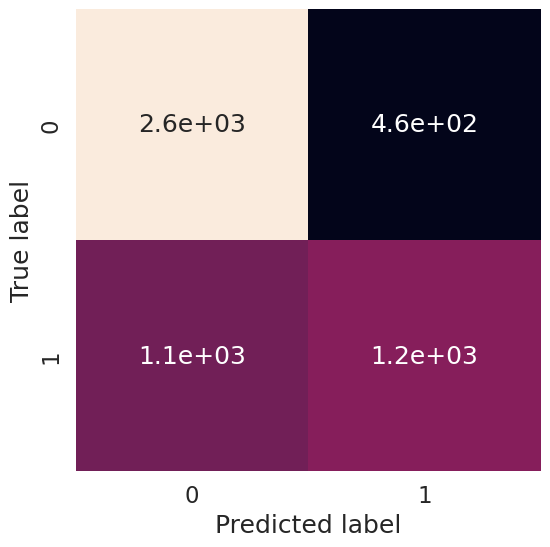

In [ ]:
sns.set_theme(font_scale=1.5)

def plot_conf_mat(y_test, y_preds):
    """
    Plots a nice looking confusion matrix using Seaborn's heatmap().
    """
    matrix = confusion_matrix(y_test, y_preds)
    print(matrix)
    
    fig, ax = plt.subplots(figsize=(6, 6))
    ax = sns.heatmap(
        matrix,
        annot=True, # Annotate the boxes
        cbar=False
    )
    plt.xlabel("Predicted label") # predictions go on the x-axis
    plt.ylabel("True label") # true labels go on the y-axis 

y_preds = model.predict(X_test)
plot_conf_mat(y_test, y_preds)

In [ ]:
print(
    classification_report(y_test, preds)
)

              precision    recall  f1-score   support

       False       0.71      0.85      0.77      3062
        True       0.72      0.52      0.61      2269

    accuracy                           0.71      5331
   macro avg       0.71      0.69      0.69      5331
weighted avg       0.71      0.71      0.70      5331



['remaining_days' 0.057808243921172425]
['registration_init_time_day' 0.04003086418601165]
['num_unq' 0.03918442534230563]
['total_secs' 0.038841106847723704]
['is_auto_renew' 0.037466391425687126]
['num_100' 0.03549805551155603]
['num_unq-1M' 0.03402230665306188]
['num_25' 0.03374969931156281]
['total_secs-1M' 0.0333024640247926]
['num_unq-2M' 0.033168447252010916]
['num_100-1M' 0.03267840279120143]
['total_secs-2M' 0.03264244957277162]
['num_100-2M' 0.03262423523016422]
['num_25-1M' 0.030490789762483907]
['num_25-2M' 0.029404135278672805]
['num_50' 0.028117331748404414]
['registration_init_time_year' 0.0276472865637282]
['num_75' 0.026472609929110366]
['num_50-1M' 0.026471633839037487]
['num_50-2M' 0.026448675315868628]
['num_985' 0.02576918124488976]
['payment_method_id_39' 0.025716483937800894]
['num_75-1M' 0.02500864508729978]
['num_985-2M' 0.02468235205910048]
['num_985-1M' 0.023983908142043753]
['is_cancel' 0.02389876896596597]
['num_75-2M' 0.02387578634502707]
['payment_method_

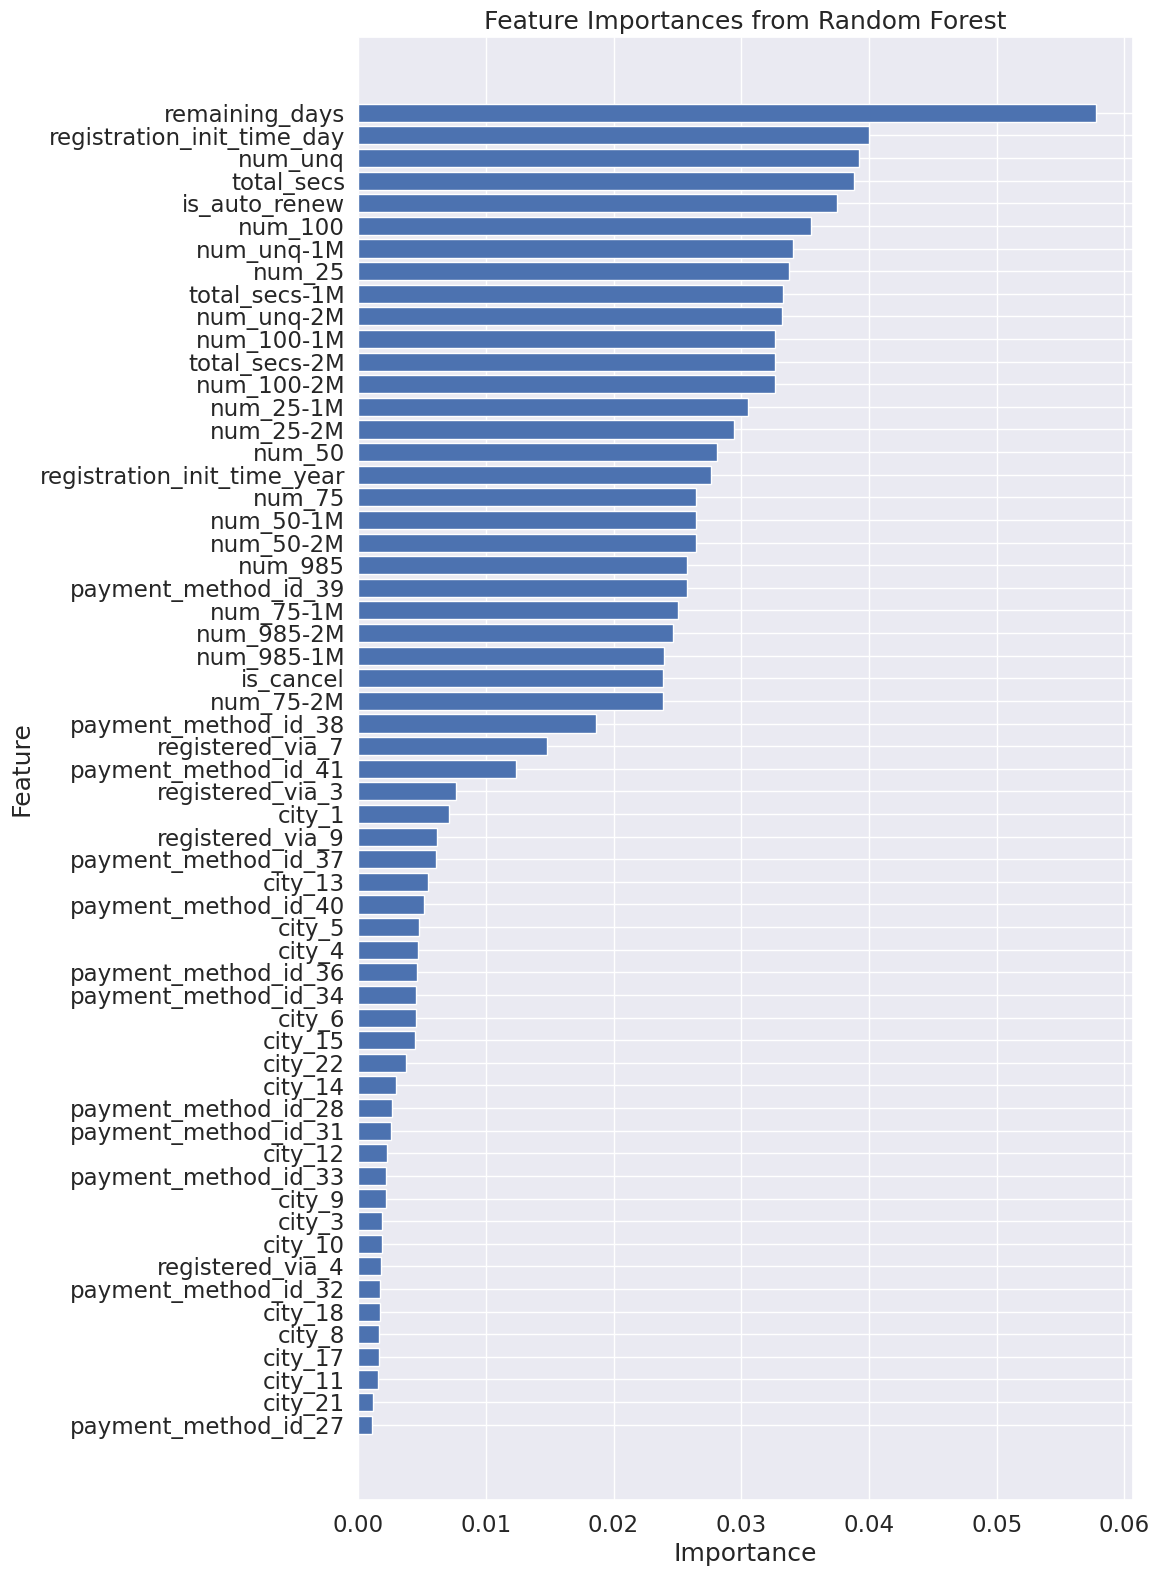

In [ ]:
import matplotlib.pyplot as plt

# Get feature importances
importances = model.feature_importances_
feature_names = X.drop('safra', axis=1).columns

# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# feature_importances = feature_importances[:50]

for f in feature_importances.values:
    print(f)

feature_importances = feature_importances[feature_importances['Importance'] >= 0.001]

# Plot the feature importances
plt.figure(figsize=(10, 19))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances - Random Forest')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()

In [49]:
SAVED_MODEL_FILENAME = './models/random_forest_model_' + datetime.now().strftime('%Y-%m-%d-%Hh-%Mm') + '.joblib'
joblib.dump(model, SAVED_MODEL_FILENAME)
print(F"'{SAVED_MODEL_FILENAME}'")

'./models/random_forest_model_2025-04-08-19h-28m.joblib'


In [50]:
input(f'EDITE O PARÂMETRO "SELECTED_MODEL" DENTRO DE project_config.py com {SAVED_MODEL_FILENAME}')

''

In [46]:
loaded_model = joblib.load(SAVED_MODEL_FILENAME)
loaded_model

RandomForestClassifier(bootstrap=False, max_depth=30, max_features='log2',
                       min_samples_split=10, random_state=42)